<a href="https://colab.research.google.com/github/coldsober-irene/ASSIGNMENTS/blob/main/HAR_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##metadata

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##packages

In [5]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping


# 1. **Frames sampling**


In [6]:
samples = 20
rate = 7

In [7]:
class Sampling:
  count = 0
  def __init__(self, base_dir, sampling_type = 'uniform', ref_mean=[0.07, 0.07, 0.07], ref_std=[0.1, 0.09, 0.08], enhance_img = False):
    self.data_path = base_dir
    self.sampling_type = sampling_type
    self.mean = ref_mean
    self.std = ref_std
    self.enhance_img = enhance_img

    # READ MAPPING FILE TO KNOW THE LABEL FOR EACH CLASS
    map_file = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/mapping_table_23.txt'
    self.maps = {}
    with open(map_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.split()
            self.maps[parts[1]] = int(parts[0])

    # CREATE EXTRACTOR OBJECT
    self.Extractor = self.Feature_extract(sampled_type = self.sampling_type)

    # subfolders
    self.activities = os.listdir(self.data_path)

    # EXTRACTED FEATURES FROM ALL THE VIDEOS
    self.obtained_features = []
    # LABELS OF THE EXTRACTED FEATURES
    self.labels = []
    Sampling.count += 1

  def saveFeatures(self):
    # CREATE VSTACK ARRAY OF ALL FEATURES EXTRACTED
    all_features = np.vstack(self.obtained_features)
    labels = np.array(self.labels)

    # SAVED THE EXTRACTED FEATURES and their corresponding labels FOR FUTURE USE
    features_dir = os.path.join(self.data_path, 'features')
    os.makedirs(features_dir, exist_ok = True)

    np.save(os.path.join(features_dir,f'features{Sampling.count}.npy'), all_features)
    np.save(os.path.join(features_dir,f'labels{Sampling.count}.npy'), labels)

    print("FEATURE EXTRACTION AND SAVING IS DONE!!!")

  def enhance_image(self, input_frame, gamma=0.35, kernel_size=3):
    # Apply gamma correction
    gamma_corrected = np.power(input_frame / 255.0, gamma) * 255.0
    gamma_corrected = gamma_corrected.astype(np.uint8)

    # Return the gamma_corrected image
    return gamma_corrected

  def Sampler(self, sample_rate = 5, num_samples = 10):
    # Loop through each activity
    for activity in self.activities:
        activity_folder = os.path.join(self.data_path, activity)

        # Loop through video files in the activity folder
        for video_file in os.listdir(activity_folder):
            if '.mp4' in video_file:
              frames_sampled = []
              video_path = os.path.join(activity_folder, video_file)
              cap = cv2.VideoCapture(video_path)

              frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

              if self.sampling_type == 'uniform':
                sample = self.UniformSampling(cap = cap, frameCount=frame_count, sample_rate = sample_rate)
                frames_sampled.append(sample)

              elif self.sampling_type == 'random':
                sample = self.RandomSampling(cap = cap, frameCount=frame_count, num_samples=num_samples)
                frames_sampled.append(sample)

              # EXTRACT FEATURE FROM THE FRAMES OF EACH VIDEO
              features_obtained = self.Extractor.features(frames = frames_sampled, ref_mean = self.mean, ref_std = self.std)
              self.obtained_features.append(features_obtained)

              # POPULATE THE LABEL CORRESPONDING TO THE CURRENT VIDEO
              self.labels.append(self.maps[activity])

  def UniformSampling(self, cap, sample_rate, frameCount):
    for i in range(0, frameCount, sample_rate):
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()
      if ret:
        if self.enhance_img:
          return self.enhance_image(input_frame = frame)
        return frame

  def RandomSampling(self, cap,num_samples, frameCount):
    sampled_indices = random.sample(range(frameCount), num_samples)

    for i in sampled_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
          if self.enhance_img:
            return self.enhance_image(input_frame = frame)
          return frame

  class Feature_extract:
    def __init__(self, sampled_type = 'uniform'):
      # Load pre-trained ResNet50
      self.model = ResNet50(weights='imagenet', include_top=False)
      self.sampled_type = sampled_type

    # Function to normalize a frame
    def normalize_frame(self, frame, ref_mean, ref_std):
        actual_mean = np.mean(frame, axis=(0, 1), keepdims=True)
        actual_std = np.std(frame, axis=(0, 1))
        normalized_frame = (frame - actual_mean) / actual_std * ref_std + ref_mean
        return normalized_frame

    # Function to preprocess frames and extract features using ResNet
    def features(self,frames, ref_mean, ref_std):
        processed_frames = [self.normalize_frame(frame, ref_mean, ref_std) for frame in frames]
        processed_frames = [preprocess_input(frame) for frame in processed_frames]
        features = self.model.predict(np.array(processed_frames))
        return features


RUN EXTRACTION OF THE TRAIN DATASETS

uniform sampling

In [8]:
%%capture
data_root = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/train'
sample = Sampling(base_dir = data_root)
sample.Sampler(sample_rate = rate)
sample.saveFeatures()


random sampling

In [9]:
%%capture
sample2 = Sampling(base_dir = data_root, sampling_type = 'random')
sample2.Sampler(num_samples=samples)
sample2.saveFeatures()

#2. **validation data feature extraction**

In [10]:
class ValSampling:
  count = 0
  def __init__(self, base_dir, sampling_type = 'uniform', ref_mean=[0.07, 0.07, 0.07], ref_std=[0.1, 0.09, 0.08], enhance_img = False):
    self.data_path = base_dir
    self.sampling_type = sampling_type
    self.mean = ref_mean
    self.std = ref_std
    self.enhance_img = enhance_img

    # READ MAPPING FILE TO KNOW THE LABEL FOR EACH CLASS
    map_file = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate.txt'
    self.maps = {}
    with open(map_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.split()
            self.maps[parts[-1]] = int(parts[1])

    # CREATE EXTRACTOR OBJECT
    self.Extractor = self.Feature_extract(sampled_type = self.sampling_type)


    # EXTRACTED FEATURES FROM ALL THE VIDEOS
    self.obtained_features = []
    # LABELS OF THE EXTRACTED FEATURES
    self.labels = []
    ValSampling.count += 1

  def saveFeatures(self):
    # CREATE VSTACK ARRAY OF ALL FEATURES EXTRACTED
    all_features = np.vstack(self.obtained_features)
    labels = np.array(self.labels)

    # SAVED THE EXTRACTED FEATURES and their corresponding labels FOR FUTURE USE
    features_dir = os.path.join(self.data_path, 'features')
    os.makedirs(features_dir, exist_ok = True)

    np.save(os.path.join(features_dir,f'features{ValSampling.count}.npy'), all_features)
    np.save(os.path.join(features_dir,f'labels{ValSampling.count}.npy'), labels)

    print("VALIDATION FEATURE EXTRACTION AND SAVING IS DONE!!!")

  def enhance_image(self, input_frame, gamma=0.35, kernel_size=3):
    # Apply gamma correction
    gamma_corrected = np.power(input_frame / 255.0, gamma) * 255.0
    gamma_corrected = gamma_corrected.astype(np.uint8)

    # Return the gamma_corrected image
    return gamma_corrected

  def Sampler(self, sample_rate = 5, num_samples = 10):
    # Loop through video files in the activity folder
    for video_file in os.listdir(self.data_path):
        if '.mp4' in video_file:
          frames_sampled = []
          video_path = os.path.join(self.data_path, video_file)
          cap = cv2.VideoCapture(video_path)

          frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

          if self.sampling_type == 'uniform':
            sample = self.UniformSampling(cap = cap, frameCount=frame_count, sample_rate = sample_rate)
            frames_sampled.append(sample)

          elif self.sampling_type == 'random':
            sample = self.RandomSampling(cap = cap, frameCount=frame_count, num_samples=num_samples)
            frames_sampled.append(sample)

          # EXTRACT FEATURE FROM THE FRAMES OF EACH VIDEO
          features_obtained = self.Extractor.features(frames = frames_sampled, ref_mean = self.mean, ref_std = self.std)
          self.obtained_features.append(features_obtained)

          # POPULATE THE LABEL CORRESPONDING TO THE CURRENT VIDEO
          self.labels.append(self.maps[video_file])

  def UniformSampling(self, cap, sample_rate, frameCount):
    for i in range(0, frameCount, sample_rate):
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()
      if ret:
        if self.enhance_img:
          return self.enhance_image(input_frame = frame)
        return frame

  def RandomSampling(self, cap,num_samples, frameCount):
    sampled_indices = random.sample(range(frameCount), num_samples)

    for i in sampled_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
          if self.enhance_img:
            return self.enhance_image(input_frame = frame)
          return frame

  class Feature_extract:
    def __init__(self, sampled_type = 'uniform'):
      # Load pre-trained ResNet50
      self.model = ResNet50(weights='imagenet', include_top=False)
      self.sampled_type = sampled_type

    # Function to normalize a frame
    def normalize_frame(self, frame, ref_mean, ref_std):
        actual_mean = np.mean(frame, axis=(0, 1), keepdims=True)
        actual_std = np.std(frame, axis=(0, 1))
        normalized_frame = (frame - actual_mean) / actual_std * ref_std + ref_mean
        return normalized_frame

    # Function to preprocess frames and extract features using ResNet
    def features(self,frames, ref_mean, ref_std):
        processed_frames = [self.normalize_frame(frame, ref_mean, ref_std) for frame in frames]
        processed_frames = [preprocess_input(frame) for frame in processed_frames]
        features = self.model.predict(np.array(processed_frames))
        return features


In [11]:
def plotting(model):
  # Access training history
  training_accuracy = model.history['accuracy']
  validation_accuracy = model.history['val_accuracy']
  training_loss = model.history['loss']
  validation_loss = model.history['val_loss']
  # Plot the training and validation accuracy
  plt.figure(figsize=(10, 6))
  plt.plot(training_accuracy, label='Training Accuracy')
  plt.plot(validation_accuracy, label='Validation Accuracy')
  plt.plot(training_loss, label='Training loss')
  plt.plot(validation_loss, label='Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation')
  plt.legend()
  plt.grid(True)
  plt.show()

RUN EXTRACTION OF THE VALIDATION DATASETS

uniform sampling

In [12]:
%%capture
val_root = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate'
sample_val = ValSampling(base_dir = val_root)
sample_val.Sampler(sample_rate = rate)
sample_val.saveFeatures()

random sampling

In [13]:
%%capture
sample_val2 = ValSampling(base_dir = val_root, sampling_type = 'random')
sample_val2.Sampler(num_samples=samples)
sample_val2.saveFeatures()

### obtain the features of each frame using a pre-trained model and create feature vector

## fuse features extracted using average pooling

## Question: ***Describe in brief the pre-trained model leveraged and why the pre-trained model is selected. What is the dimension of the feature obtained. Remember to save the video features in order for subsequent training. (3 points)***

# 3. **Classifier Training and Evaluation**

**possible classifier I can choose from since my datasets are small (just 25 videos)**

1.   Support Vector Machines (SVM)
2.   Naive Bayes
3. Random Forest





In [14]:
val_base = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate'
feature_dir = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/train/features/features1.npy'
labels_dir = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/train/features/labels1.npy'
val_features = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/features/features1.npy'
val_labels = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/features/labels1.npy'
X_train = np.load(feature_dir, allow_pickle = True)
y_train = np.load(labels_dir, allow_pickle = True)
X_val = np.load(val_features, allow_pickle = True)
y_val = np.load(val_labels, allow_pickle = True)

In [15]:
val_size = 0.64
shuffle = True
num_classes = 6
epoch = 300
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [16]:
features = np.vstack([X_train, X_val])
# print(y_train)
# print(y_val)
labels = np.hstack([y_train, y_val])
# print(labels.shape)
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=val_size, shuffle = shuffle, random_state=42)
# DIR FOR MODEL
BASE_DIR ='/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/models'
os.makedirs(BASE_DIR, exist_ok = True)

##model training under **uniform** sampled data

Epoch 1/300
3/3 [==============================] - 2s 663ms/step - loss: 2.7665 - accuracy: 0.1250 - val_loss: 2.3495 - val_accuracy: 0.1709
Epoch 2/300
3/3 [==============================] - 1s 570ms/step - loss: 2.4485 - accuracy: 0.1477 - val_loss: 2.3081 - val_accuracy: 0.1646
Epoch 3/300
3/3 [==============================] - 2s 610ms/step - loss: 2.0902 - accuracy: 0.1932 - val_loss: 1.9396 - val_accuracy: 0.1582
Epoch 4/300
3/3 [==============================] - 1s 308ms/step - loss: 1.8354 - accuracy: 0.1932 - val_loss: 1.8612 - val_accuracy: 0.1709
Epoch 5/300
3/3 [==============================] - 1s 334ms/step - loss: 1.8528 - accuracy: 0.1818 - val_loss: 1.7921 - val_accuracy: 0.1772
Epoch 6/300
3/3 [==============================] - 1s 275ms/step - loss: 1.7833 - accuracy: 0.2159 - val_loss: 1.8817 - val_accuracy: 0.1582
Epoch 7/300
3/3 [==============================] - 1s 316ms/step - loss: 1.8005 - accuracy: 0.1818 - val_loss: 1.8342 - val_accuracy: 0.1456
Epoch 8/300
3

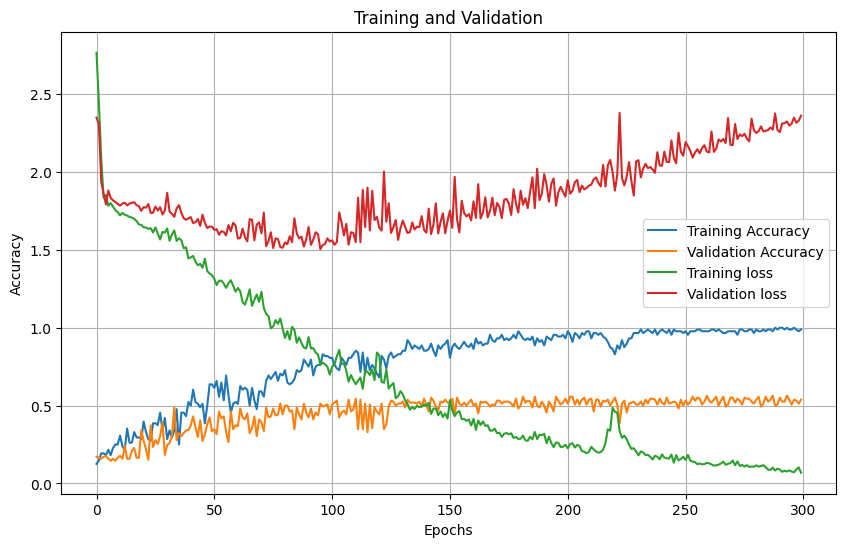

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:

# Define the model with 3D convolutional layers
model = keras.Sequential([
    layers.Input(shape=X_train.shape[1:]),  # Input shape matches your feature shape
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer with the number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelHistory = model.fit(X_train, y_train, epochs=epoch, validation_data=(X_val, y_val)) # , callbacks=[early_stopping]
plotting(modelHistory)
model.save(os.path.join(BASE_DIR,'uniform_model.h5'))


In [18]:
print(modelHistory.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


###model training under random sampled frames

In [19]:
val_base = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate'
feature_dir2 = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/train/features/features2.npy'
labels_dir2 = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/train/features/labels2.npy'
val_features2 = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/features/features2.npy'
val_labels2 = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/features/labels2.npy'
X_train2 = np.load(feature_dir2, allow_pickle = True)
y_train2 = np.load(labels_dir2, allow_pickle = True)
X_val2 = np.load(val_features2, allow_pickle = True)
y_val2 = np.load(val_labels2, allow_pickle = True)

In [21]:

features2 = np.vstack([X_train2, X_val2])
# print(y_train)
# print(y_val)
labels2 = np.hstack([y_train2, y_val2])
# print(labels.shape)
X_train2, X_val2, y_train2, y_val2 = train_test_split(features2, labels2, test_size=val_size, shuffle = shuffle, random_state=42)

Epoch 1/300
3/3 [==============================] - 2s 538ms/step - loss: 2.6835 - accuracy: 0.1477 - val_loss: 3.4918 - val_accuracy: 0.1709
Epoch 2/300
3/3 [==============================] - 1s 341ms/step - loss: 2.6517 - accuracy: 0.1705 - val_loss: 2.1815 - val_accuracy: 0.1646
Epoch 3/300
3/3 [==============================] - 1s 314ms/step - loss: 2.2153 - accuracy: 0.2159 - val_loss: 1.9548 - val_accuracy: 0.1709
Epoch 4/300
3/3 [==============================] - 1s 347ms/step - loss: 1.8242 - accuracy: 0.1364 - val_loss: 1.9905 - val_accuracy: 0.1709
Epoch 5/300
3/3 [==============================] - 1s 334ms/step - loss: 1.9980 - accuracy: 0.1932 - val_loss: 1.9469 - val_accuracy: 0.1456
Epoch 6/300
3/3 [==============================] - 1s 324ms/step - loss: 1.8866 - accuracy: 0.2045 - val_loss: 1.8724 - val_accuracy: 0.2342
Epoch 7/300
3/3 [==============================] - 1s 587ms/step - loss: 1.8408 - accuracy: 0.1705 - val_loss: 1.8344 - val_accuracy: 0.1709
Epoch 8/300
3

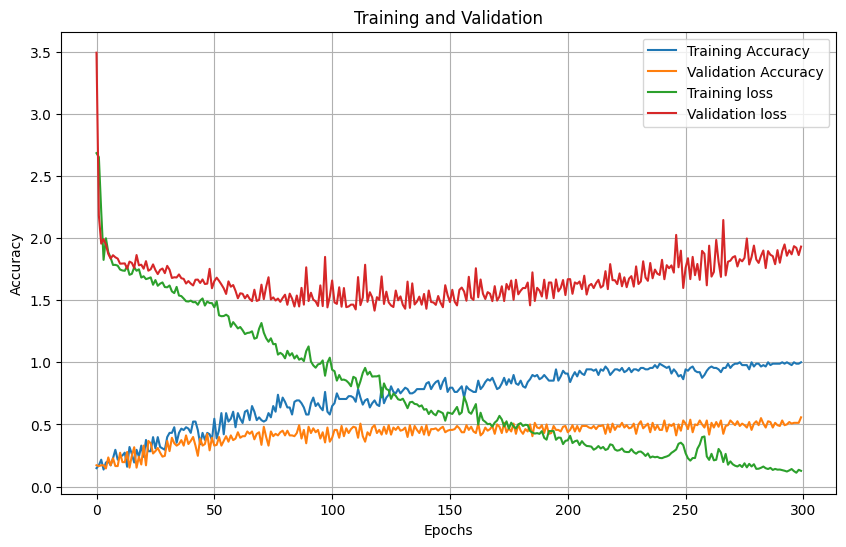

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Define the model with 3D convolutional layers

model = keras.Sequential([
    layers.Input(shape=X_train2.shape[1:]),  # Input shape matches your feature shape
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer with the number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelHistory = model.fit(X_train2, y_train2, epochs=epoch, validation_data=(X_val2, y_val2)) # , callbacks=[early_stopping]
plotting(modelHistory)
model.save(os.path.join(BASE_DIR,'random_model.h5'))

###avoiding overfitting

Epoch 1/300
3/3 [==============================] - 2s 475ms/step - loss: 2.8419 - accuracy: 0.2727 - val_loss: 1.9382 - val_accuracy: 0.1456
Epoch 2/300
3/3 [==============================] - 1s 505ms/step - loss: 2.2901 - accuracy: 0.1818 - val_loss: 1.7937 - val_accuracy: 0.1835
Epoch 3/300
3/3 [==============================] - 1s 344ms/step - loss: 1.8190 - accuracy: 0.1364 - val_loss: 1.7918 - val_accuracy: 0.1709
Epoch 4/300
3/3 [==============================] - 1s 334ms/step - loss: 1.7967 - accuracy: 0.1591 - val_loss: 1.7919 - val_accuracy: 0.1709
Epoch 5/300
3/3 [==============================] - 1s 335ms/step - loss: 1.7917 - accuracy: 0.1591 - val_loss: 1.7919 - val_accuracy: 0.1709
Epoch 6/300
3/3 [==============================] - 1s 360ms/step - loss: 1.7912 - accuracy: 0.1477 - val_loss: 1.7920 - val_accuracy: 0.1709
Epoch 7/300
3/3 [==============================] - 1s 330ms/step - loss: 1.7911 - accuracy: 0.1477 - val_loss: 1.7922 - val_accuracy: 0.1709
Epoch 8/300
3

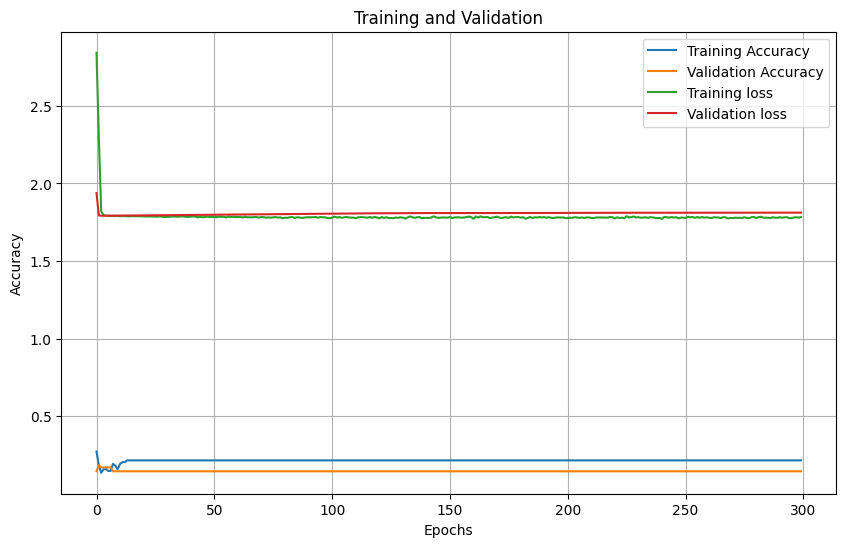

In [23]:
# Add dropout layers to the model
model = keras.Sequential([
    layers.Input(shape=X_train2.shape[1:]),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Experiment with dropout rate
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Experiment with dropout rate
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelHistory = model.fit(X_train2, y_train2, epochs=epoch, validation_data=(X_val2, y_val2)) # , callbacks=[early_stopping]
plotting(modelHistory)

### Discuss the pros and cons of the type of classifier selected

## evaluate the trained classifier

### You should repeat steps 1 and 2 for the validation videos to obtain their features and obtain their class predictions with the trained classifier. Compare the predictions with the ground truth label. What is the performance of the trained classifier? (3 points)

#4. **Apply any image enhancement of your choice** and explore how it effects the performance of the trained classifier. Note that the reference mean, and standard deviation value of a normal video frame is "mean" [0.485,0.456,0.406],"standard deviation" [0.229,0.224,0.225].

In [24]:
%%capture
data_root = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/train'
en_sample = Sampling(base_dir = data_root, enhance_img=True)
en_sample.Sampler(sample_rate = rate)
en_sample.saveFeatures()

val_root = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate'
en_sample_val = ValSampling(base_dir = val_root, enhance_img = True)
en_sample_val.Sampler(sample_rate = rate)
en_sample_val.saveFeatures()


In [25]:
feature_dir3 = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/train/features/features3.npy'
labels_dir3 = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/train/features/labels3.npy'
val_features3 = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/features/features3.npy'
val_labels3 = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/features/labels3.npy'
X_train3 = np.load(feature_dir3, allow_pickle = True)
y_train3 = np.load(labels_dir3, allow_pickle = True)
X_val3 = np.load(val_features3, allow_pickle = True)
y_val3 = np.load(val_labels3, allow_pickle = True)

In [26]:
features3 = np.vstack([X_train3, X_val3])
# print(y_train)
# print(y_val)
labels3 = np.hstack([y_train3, y_val3])
# print(labels.shape)
X_train3, X_val3, y_train3, y_val3 = train_test_split(features3, labels3, test_size=val_size, shuffle = shuffle, random_state=42)

Epoch 1/300
3/3 [==============================] - 2s 669ms/step - loss: 2.6165 - accuracy: 0.1932 - val_loss: 2.5292 - val_accuracy: 0.1456
Epoch 2/300
3/3 [==============================] - 1s 487ms/step - loss: 2.4539 - accuracy: 0.1818 - val_loss: 2.0452 - val_accuracy: 0.1646
Epoch 3/300
3/3 [==============================] - 1s 513ms/step - loss: 1.9007 - accuracy: 0.2273 - val_loss: 2.0248 - val_accuracy: 0.2025
Epoch 4/300
3/3 [==============================] - 1s 528ms/step - loss: 1.9955 - accuracy: 0.1136 - val_loss: 1.8089 - val_accuracy: 0.1709
Epoch 5/300
3/3 [==============================] - 1s 416ms/step - loss: 1.8206 - accuracy: 0.1705 - val_loss: 1.9232 - val_accuracy: 0.2152
Epoch 6/300
3/3 [==============================] - 1s 327ms/step - loss: 1.8011 - accuracy: 0.2500 - val_loss: 1.8661 - val_accuracy: 0.1456
Epoch 7/300
3/3 [==============================] - 1s 329ms/step - loss: 1.8048 - accuracy: 0.2045 - val_loss: 1.8193 - val_accuracy: 0.1772
Epoch 8/300
3

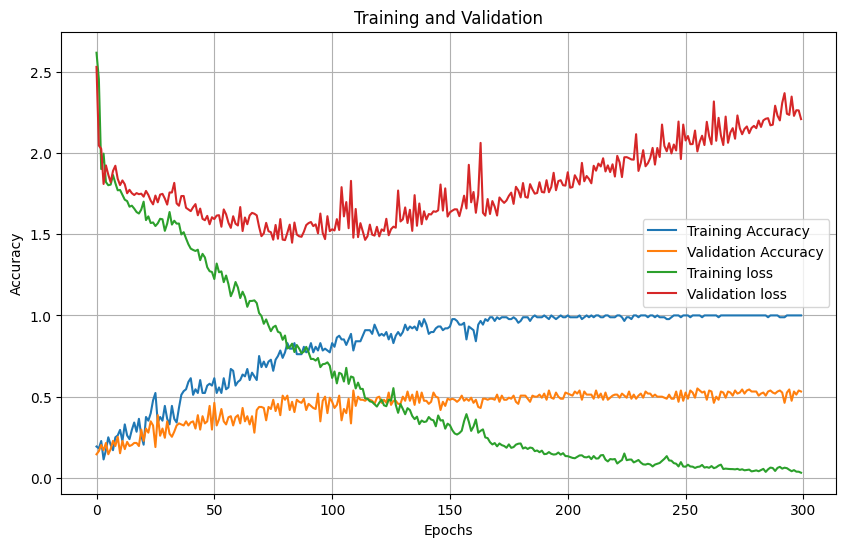

In [27]:
model = keras.Sequential([
    layers.Input(shape=X_train3.shape[1:]),  # Input shape matches your feature shape
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer with the number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modelHistory = model.fit(X_train3, y_train3, epochs=epoch, validation_data=(X_val3, y_val3)) # , callbacks=[early_stopping]
plotting(modelHistory)
model.save(os.path.join(BASE_DIR,'enhanced_model.h5'))

### Discuss how the chosen image enhancement effects the performance of the trained classifier in detail

### Provide sampled output frames resulting from the image enhancement. (6 points)

# 3. model evaluation

In [29]:
saved_validation_data = {'enhanced validation':('/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/features/features3.npy','/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/features/labels3.npy'),
'uniform sampled validation':('/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/features/features1.npy',
'/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/features/labels1.npy'),
'random validation':('/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/features/features2.npy',
'/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/features/labels2.npy')}

results = {}
for k, v in saved_validation_data.items():
  X_val = np.load(v[0], allow_pickle = True)
  y_val = np.load(v[1], allow_pickle = True)
  BASE_DIR = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/models'
  models = os.listdir(BASE_DIR)
  # Load your saved model
  model = keras.models.load_model(os.path.join(BASE_DIR, f'{k.split()[0]}_model.h5'))
  # Evaluate the model on the test data
  test_loss, test_accuracy = model.evaluate(X_val, y_val)

  # Print the evaluation results

  print("enhanced images sample")
  print("-"*100)
  print(f'Test Loss: {test_loss}')
  print(f'Test Accuracy: {test_accuracy}')
  results[k.split()[0]] = (test_loss, test_accuracy)



3/3 [==============================] - 0s 50ms/step - loss: 2.1760 - accuracy: 0.5938
enhanced images sample
----------------------------------------------------------------------------------------------------
Test Loss: 2.1760456562042236
Test Accuracy: 0.59375
3/3 [==============================] - 0s 44ms/step - loss: 2.2233 - accuracy: 0.6354
enhanced images sample
----------------------------------------------------------------------------------------------------
Test Loss: 2.2233188152313232
Test Accuracy: 0.6354166865348816
3/3 [==============================] - 0s 44ms/step - loss: 1.7284 - accuracy: 0.6562
enhanced images sample
----------------------------------------------------------------------------------------------------
Test Loss: 1.7283679246902466
Test Accuracy: 0.65625


In [30]:
results

{'enhanced': (2.1760456562042236, 0.59375),
 'uniform': (2.2233188152313232, 0.6354166865348816),
 'random': (1.7283679246902466, 0.65625)}

# 5. – Improving the HAR Model to Enable End-to-end Training. The aforementioned method is intuitive but is not end-to-end, which limits its applicability in real-world scenarios. Currently, most HAR models are designed end-to-end, without the need to explicitly store the video features. In this step you are to design or implement an HAR model that is end-to-end and evaluate your HAR model. Describe your HAR model in detail, including the structure along with the training and evaluation procedures. Compare your HAR model performance against the prior trained classifiers and discuss the pros and cons of your HAR model. (Additional 10 points)

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, LSTM, Dense, Flatten, Input
# from tensorflow.keras.models import Model
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Assuming you have your training data in train_videos and train_labels
# # Assuming you have your validation data in validation_videos and validation_labels

# # Define the input shape
# input_shape = (sequence_length, frame_height, frame_width, num_channels)

# # Build the end-to-end HAR model
# input_layer = Input(shape=input_shape)
# conv_layer = Conv2D(32, (3, 3), activation='relu')(input_layer)
# lstm_layer = LSTM(64, return_sequences=True)(conv_layer)
# flatten_layer = Flatten()(lstm_layer)
# output_layer = Dense(num_classes, activation='softmax')(flatten_layer)

# model = Model(inputs=input_layer, outputs=output_layer)

# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
# model.fit(train_videos, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_videos, validation_labels))

# # Evaluate the model on the validation set
# validation_predictions = model.predict(validation_videos)
# validation_predictions = np.argmax(validation_predictions, axis=1)  # Assuming one-hot encoding of labels
# validation_labels = np.argmax(validation_labels, axis=1)  # Assuming one-hot encoding of labels

# accuracy = accuracy_score(validation_labels, validation_predictions)
# precision = precision_score(validation_labels, validation_predictions, average='weighted')
# recall = recall_score(validation_labels, validation_predictions, average='weighted')
# f1 = f1_score(validation_labels, validation_predictions, average='weighted')

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)


In [ ]:
# from shutil import rmtree
# b = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/train/uniform_sampled'
# # # c = '/content/drive/MyDrive/machine vision assignment 2/EE6222 train and validate 2023/validate/uniform_validation_sampled'
# # # # for file in os.listdir(b):
# # # #   os.unlink(os.path.join(b, file))
# rmtree(b)

# for f in os.listdir(c):
#   os.unlink(os.path.join(c, file))
  # rmtree(os.path.join(c, f))